In [1]:
%load_ext autoreload
%autoreload 2

import torch
import numpy as np
import matplotlib.pyplot as plt
import os
import sys
import argparse

os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"   # see issue #152
os.environ["CUDA_VISIBLE_DEVICES"]="0"

In [2]:
from neus.fields import SDFNetwork, RenderingNetwork, NeRF, SingleVarianceNetwork
from neus.network import NeuSNetwork

Unable to load the following plugins:

	libio_e57.so: libio_e57.so does not seem to be a Qt Plugin.

Cannot load library /home/dmitry/.virtualenv/dreamfusion/lib/python3.10/site-packages/pymeshlab/lib/plugins/libio_e57.so: (/lib/x86_64-linux-gnu/libp11-kit.so.0: undefined symbol: ffi_type_pointer, version LIBFFI_BASE_7.0)



In [3]:
from pyhocon import ConfigFactory

In [4]:
parser = argparse.ArgumentParser()
parser.add_argument('--conf', type=str, default='./confs/base.conf')
parser.add_argument('--mode', type=str, default='train')
parser.add_argument('--mcube_threshold', type=float, default=0.0)
parser.add_argument('--is_continue', default=False, action="store_true")
parser.add_argument('--gpu', type=int, default=0)
parser.add_argument('--case', type=str, default='')

args = parser.parse_args([
    '--conf', '/home/dmitry/clones/NeuS/confs/womask.conf',
    '--mode', 'train',
    '--mcube_threshold', '0.0',
    '--is_continue',
    '--gpu', '0',
    '--case', 'womask'
])

In [5]:
f = open(args.conf)
conf_text = f.read()
conf_text = conf_text.replace('CASE_NAME', args.case)
f.close()

conf = ConfigFactory.parse_string(conf_text)

In [6]:
class SphereSDF(torch.nn.Module):
    def __init__(self, radius, pos, appearance_dim):
        super().__init__()

        self.radius = radius
        self.pos = pos
        self.appearance_dim = appearance_dim
    def forward(self, x):
        dist = torch.norm(x - self.pos[None], dim=-1, keepdim=True) - self.radius
        hidden_appearance = (dist < 0).to(torch.float32).expand(-1, self.appearance_dim)
        return torch.cat([dist, hidden_appearance], dim=-1)
    def sdf(self, x):
        return self.forward(x)[:, :1]
    def gradient(self, x):
        x.requires_grad_(True)
        y = self.sdf(x)
        d_output = torch.ones_like(y, requires_grad=False, device=y.device)
        gradients = torch.autograd.grad(
            outputs=y,
            inputs=x,
            grad_outputs=d_output,
            create_graph=True,
            retain_graph=True,
            only_inputs=True)[0]
        return gradients.unsqueeze(1)

In [8]:
device = 'cuda:0'
model = NeuSNetwork(
    conf['model.nerf'],
    conf['model.sdf_network'],
    conf['model.variance_network'],
    conf['model.rendering_network'],
    **conf['model.neus_renderer']
).to(device)

Applying NeuS geometric init


In [9]:
rays_o = torch.rand(1, 10, 3).to(device)
rays_d = torch.rand(1, 10, 3).to(device)

### Some important notes
- Default camera position is at (0,0,0) and looks at (0,0,1)
- n_outside has to be 0 so that the background NeRF does not interfere

In [10]:
def focal_length_to_intrinsic(focal_length, H, W, device='cpu'):
    K = torch.eye(3, device=device)
    K[0, 0] = W / focal_length
    K[1, 1] = H / focal_length
    K[0, 2] = W / 2
    K[1, 2] = H / 2
    return K
def sample_rays(RT, focal_length, H, W, device='cpu'):
    """
    Input:
        RT: 4x4 - camera extrinsic matrix
        K: 3x3 - camera intrinsic matrix
        H: int - image height
        W: int - image width
    Output:
        rays_o: Nx3 - ray origins
        rays_d: Nx3 - ray directions
    """
    K = focal_length_to_intrinsic(focal_length, H, W, device=device)
    x, y = torch.meshgrid(torch.arange(W, dtype=torch.float32, device=device), torch.arange(H, dtype=torch.float32, device=device))
    x = x.reshape(-1)
    y = y.reshape(-1)
    z = torch.ones_like(x)
    rays_d_screen = torch.stack([x, y, z], axis=1)
    rays_d_camera = rays_d_screen @ torch.linalg.inv(K).T
    c2w = torch.linalg.inv(RT)
    rays_d = rays_d_camera @ c2w[:3, :3].T
    rays_o = c2w[:3, 3][None].expand(rays_d.shape[0], -1)

    return rays_o, rays_d

def sample_points(rays_o, rays_d, near, far, num_steps, device='cpu'):
    """
    Input:
        rays_o: Nx3 - ray origins
        rays_d: Nx3 - ray directions
        near: float - near plane
        far: float - far plane
    Output:
        points: Nx3 - sampled points
    """
    t = torch.linspace(near, far, steps=num_steps, device=device)
    points = rays_o[:, None] + rays_d[:, None] * t[None, :, None]
    return points

In [11]:
RT = torch.eye(4).to(device)
RT[2, 3] = 5
focal_length = 1
H = W = 32

rays_o, rays_d = sample_rays(RT, focal_length, H, W, device=device)
# points = sample_points(rays_o, rays_d, near=0.1, far=1.0, num_steps=64, device=device)

/home/dmitry/.virtualenv/dreamfusion/lib/python3.10/site-packages/torch/functional.py:504: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at ../aten/src/ATen/native/TensorShape.cpp:3483.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


In [12]:
res = model.run(
    rays_o, rays_d,
    # near=0.1, far=5.0,
    # cos_anneal_ratio=1.0
)

tensor(0., device='cuda:0') tensor(2.0848, device='cuda:0')
tensor(0., device='cuda:0') tensor(1.7902, device='cuda:0')
tensor(0., device='cuda:0') tensor(2.3307, device='cuda:0')
tensor(0., device='cuda:0') tensor(3.2500, device='cuda:0')
tensor(-0.3461, device='cuda:0') tensor(5.4170, device='cuda:0')
tensor(0., device='cuda:0', grad_fn=<MinBackward1>) tensor(2.0954, device='cuda:0', grad_fn=<MaxBackward1>)
tensor(0., device='cuda:0', grad_fn=<MinBackward1>) tensor(1.7949, device='cuda:0', grad_fn=<MaxBackward1>)
tensor(0., device='cuda:0', grad_fn=<MinBackward1>) tensor(2.3357, device='cuda:0', grad_fn=<MaxBackward1>)
tensor(0., device='cuda:0', grad_fn=<MinBackward1>) tensor(3.2629, device='cuda:0', grad_fn=<MaxBackward1>)
tensor(-0.3463, device='cuda:0', grad_fn=<MinBackward1>) tensor(5.4377, device='cuda:0', grad_fn=<MaxBackward1>)


In [16]:
model.sdf_network(torch.tensor([0.0, 0.0, 0.0]).view(1, -1).to(device) + 3)[:, :1]

tensor(0., device='cuda:0', grad_fn=<MinBackward1>) tensor(1.4846, device='cuda:0', grad_fn=<MaxBackward1>)
tensor(0., device='cuda:0', grad_fn=<MinBackward1>) tensor(1.8767, device='cuda:0', grad_fn=<MaxBackward1>)
tensor(0., device='cuda:0', grad_fn=<MinBackward1>) tensor(1.4968, device='cuda:0', grad_fn=<MaxBackward1>)
tensor(0., device='cuda:0', grad_fn=<MinBackward1>) tensor(2.3038, device='cuda:0', grad_fn=<MaxBackward1>)
tensor(3.6918, device='cuda:0', grad_fn=<MinBackward1>) tensor(3.6944, device='cuda:0', grad_fn=<MaxBackward1>)


tensor([[3.6929]], device='cuda:0', grad_fn=<SliceBackward0>)

In [17]:
rgb = res['image'].view(32, 32, 3)
weight_sum = res['weights_sum'].view(32, 32)

In [18]:
model.sdf_network.lin0.weight.mean(0)

tensor([-0.0133, -0.0120, -0.0191,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,
         0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,
         0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,
         0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,
         0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000],
       device='cuda:0', grad_fn=<MeanBackward1>)

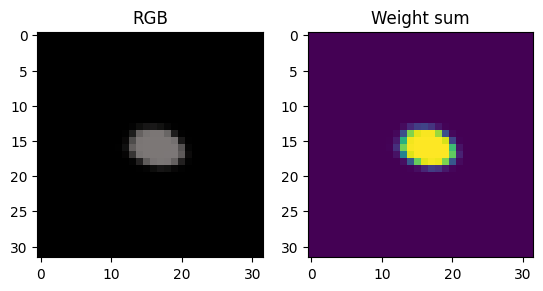

In [19]:
plt.subplot(1, 2, 1)
plt.title('RGB')
plt.imshow(rgb.detach().cpu())
plt.subplot(1, 2, 2)
plt.title('Weight sum')
plt.imshow(weight_sum.detach().cpu())

# Test that changes to the NeRFRenderer class don't change anything

In [8]:
%load_ext autoreload
%autoreload 2

from nerf.network import NeRFNetwork
from neus.renderer import NeuSRenderer, NeuSRendererNew
from main import parse_args
import torch

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [9]:
opt = parse_args("--text \"hamburger\" --workspace trial -O".split())

In [10]:
nerf_network = NeRFNetwork(opt)
nerf_network.training = False # Make everything deterministic

In [11]:
rays_o = torch.rand(1, 10, 3)
rays_d = torch.rand(1, 10, 3)

In [12]:
old_result = nerf_network.run(rays_o, rays_d, perturb=False)
# new_result = nerf_network.run_new(rays_o, rays_d, perturb=False)

In [66]:
old_result['image']

[autoreload of neus.renderer failed: Traceback (most recent call last):
  File "/home/dmitry/.virtualenv/dreamfusion/lib/python3.10/site-packages/IPython/extensions/autoreload.py", line 273, in check
    superreload(m, reload, self.old_objects)
  File "/home/dmitry/.virtualenv/dreamfusion/lib/python3.10/site-packages/IPython/extensions/autoreload.py", line 496, in superreload
    update_generic(old_obj, new_obj)
  File "/home/dmitry/.virtualenv/dreamfusion/lib/python3.10/site-packages/IPython/extensions/autoreload.py", line 393, in update_generic
    update(a, b)
  File "/home/dmitry/.virtualenv/dreamfusion/lib/python3.10/site-packages/IPython/extensions/autoreload.py", line 345, in update_class
    if update_generic(old_obj, new_obj):
  File "/home/dmitry/.virtualenv/dreamfusion/lib/python3.10/site-packages/IPython/extensions/autoreload.py", line 393, in update_generic
    update(a, b)
  File "/home/dmitry/.virtualenv/dreamfusion/lib/python3.10/site-packages/IPython/extensions/autorel

tensor([[[0.4959, 0.5629, 0.5796],
         [0.5054, 0.5031, 0.5740],
         [0.5046, 0.4714, 0.5841],
         [0.4463, 0.5485, 0.6226],
         [0.4465, 0.5464, 0.6316],
         [0.5082, 0.5443, 0.5862],
         [0.4376, 0.5120, 0.6027],
         [0.6115, 0.4207, 0.4754],
         [0.4730, 0.5293, 0.5742],
         [0.4916, 0.5071, 0.5745]]], grad_fn=<ViewBackward0>)

In [47]:
assert type(new_result) is dict, "New result is not a dict"
assert set(old_result.keys()) == set(new_result.keys()), "Key sets don't match"
for k in old_result:
    assert torch.equal(old_result[k], new_result[k]), f"Values for key {k} don't match"
print("Congratulations, everything matches!")

Congratulations, everything matches!


# Test DDIMScheduler from Diffusers

In [10]:
import torch
from sd import remove_noise, DDIMScheduler
import matplotlib.pyplot as plt
model_key = 'stabilityai/stable-diffusion-2-1-base'
scheduler = DDIMScheduler.from_pretrained(model_key, subfolder="scheduler", torch_dtype=torch.float16)

In [4]:
scheduler.num_train_timesteps

1000

In [20]:
img = torch.rand(1, 3, 64)
noise = torch.rand_like(img)
t = torch.randint(20, 980 + 1, size=[1])

In [21]:
img_noisy = scheduler.add_noise(img, noise, t)

In [22]:
img_denoised = remove_noise(scheduler, img_noisy, t, noise)

In [23]:
(img - img_denoised).abs().max()

tensor(1.1921e-07)